In [ ]:
wdimport os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score,accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
import xgboost
from sklearn.model_selection import GridSearchCV

In [ ]:
!kaggle competitions download -c fake-news

 95% 44.0M/46.5M [00:02<00:00, 33.4MB/s]
100% 46.5M/46.5M [00:02<00:00, 20.8MB/s]


In [ ]:
import zipfile
file_path="/content/fake-news.zip"

with zipfile.ZipFile(file_path,'r') as zip_ref:
      zip_ref.extractall('/content/fakenews')

In [ ]:
train=pd.read_csv("/content/fakenews/train.csv")
test=pd.read_csv("/content/fakenews/test.csv")

In [ ]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
train=train.fillna("missing")

In [ ]:
X=train.drop(['label'],axis=1)

In [ ]:
y=train['label']

In [ ]:
X.shape

(20800, 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
# Vaocab size
voc_size=160000

In [ ]:
messages=X.copy()

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Data Preprcoessing
ps=PorterStemmer()

def get_corpus(messages):
  corpus=[]
  for i in range(0,len(messages)):
    review= re.sub('[^a-zA-Z0-9]',' ',messages['title'][i])
    review=re.sub(r'[^\w\s]', '', review)
    review=review.lower()

    review= [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review=''.join(review)
    corpus.append(review)
  return corpus

In [ ]:
corpus=get_corpus(messages)

#One hot encoding

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
# Embedding representation
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[     0      0      0 ... 141154  76259  93851]
 [     0      0      0 ...  24483  69962 109681]
 [     0      0      0 ...  58694 112492  10089]
 ...
 [     0      0      0 ... 115715  79027  53839]
 [     0      0      0 ...  61240  24483  20953]
 [     0      0      0 ...   4263 105049  25321]]


In [ ]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            6400000   
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6456501 (24.63 MB)
Trainable params: 6456501 (24.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
# Model Training
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
218/218 [==============================] - 36s 147ms/step - loss: 0.3232 - accuracy: 0.8642 - val_loss: 0.1860 - val_accuracy: 0.9295
Epoch 2/10
218/218 [==============================] - 44s 200ms/step - loss: 0.1323 - accuracy: 0.9478 - val_loss: 0.1838 - val_accuracy: 0.9293
Epoch 3/10
218/218 [==============================] - 35s 159ms/step - loss: 0.0838 - accuracy: 0.9692 - val_loss: 0.1932 - val_accuracy: 0.9327
Epoch 4/10
218/218 [==============================] - 29s 134ms/step - loss: 0.0504 - accuracy: 0.9827 - val_loss: 0.2206 - val_accuracy: 0.9238
Epoch 5/10
218/218 [==============================] - 31s 141ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.2594 - val_accuracy: 0.9225
Epoch 6/10
218/218 [==============================] - 39s 179ms/step - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.3078 - val_accuracy: 0.9225
Epoch 7/10
218/218 [==============================] - 31s 142ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.3535 - val_ac

In [ ]:
from tensorflow.keras.layers import Dropout
### Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add((Dropout(0.3)))
model.add(LSTM(100))
model.add((Dropout(0.3)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

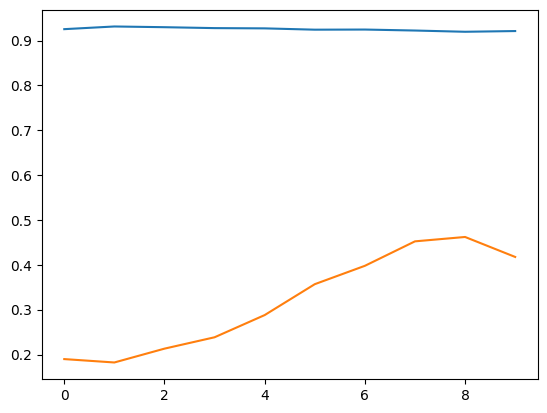

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.show;

In [ ]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
class AUCEvaluationCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUCEvaluationCallback, self).__init__()
        self.validation_data = validation_data
        self.auc_scores = []  # List to store epoch-wise AUC scores

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        self.auc_scores.append(auc)  # Append AUC score to the list

    def get_auc_scores(self):
        return self.auc_scores

In [ ]:
auc_callback = AUCEvaluationCallback(validation_data=(X_val, y_val))
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=4, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[auc_callback, early_stopping_callback])

# Access epoch-wise AUC scores
epoch_wise_auc = callback.get_auc_scores()

Epoch 1/10
218/218 [==============================] - 31s 130ms/step - loss: 0.3409 - accuracy: 0.8475 - val_loss: 0.1913 - val_accuracy: 0.9250
Epoch 2/10
218/218 [==============================] - 28s 129ms/step - loss: 0.1464 - accuracy: 0.9407 - val_loss: 0.1876 - val_accuracy: 0.9282
Epoch 3/10
218/218 [==============================] - 29s 132ms/step - loss: 0.1016 - accuracy: 0.9609 - val_loss: 0.1940 - val_accuracy: 0.9257
Epoch 4/10
218/218 [==============================] - 27s 122ms/step - loss: 0.0754 - accuracy: 0.9720 - val_loss: 0.2443 - val_accuracy: 0.9299
Epoch 5/10
218/218 [==============================] - 26s 121ms/step - loss: 0.0517 - accuracy: 0.9813 - val_loss: 0.2226 - val_accuracy: 0.9280
Epoch 6/10
218/218 [==============================] - 27s 122ms/step - loss: 0.0416 - accuracy: 0.9856 - val_loss: 0.2258 - val_accuracy: 0.9213
Epoch 7/10
218/218 [==============================] - 25s 116ms/step - loss: 0.0321 - accuracy: 0.9892 - val_loss: 0.2859 - val_ac

In [ ]:
epoch_wise_auc

[0.9722737551614894,
 0.976077094088426,
 0.9757706840567872,
 0.976326365313943,
 0.9742827403024282,
 0.9721063291203722,
 0.9703059048668594,
 0.9704552468578962,
 0.9693030466530288,
 0.9685297624834068]

In [ ]:
y_pred=model.predict(X_test)

215/215 [==============================] - 1s 6ms/step


In [ ]:
y_preds=(y_pred>0.5).astype(int)

In [ ]:
roc_auc_score(y_test,y_preds)

0.9157457314637426

In [ ]:
f1_score(y_test,y_preds)
precision_score(y_test,y_preds)
accuracy_score(y_test,y_preds)
recall_score(y_test,y_preds)

0.914598108747045

0.9230539815090963

0.9157925407925408

0.9062957540263543

# Hypertune LSTM

In [ ]:
!pip install tensorflow-addons
#!pip install keras==2.14.0
#!pip install tensorflow==2.14.0
#!pip install scikeras

In [ ]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [ ]:
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
# Define the model creation function
def create_model(num_lstm_layers=1, lstm_units=100, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
    model.add(Dropout(dropout_rate))

    # Add the specified number of LSTM layers
    for _ in range(num_lstm_layers):
        model.add(LSTM(lstm_units, return_sequences=True, kernel_initializer=glorot_uniform(seed=42)))

    # Add the final LSTM layer without return_sequences=True
    model.add(LSTM(lstm_units, kernel_initializer=glorot_uniform(seed=42)))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
import itertools

# Define the values for each hyperparameter
num_lstm_layers = [1, 2, 3]
lstm_units = [50, 100, 150]
dropout_rate = [0.2, 0.3, 0.4]
embedding_vector_features = [40, 50]
optimizer = ['adam', 'rmsprop']
learning_rate = [0.001, 0.01]
batch_size = [32, 64]
epochs = [5, 10]

# Generate all possible combinations
hyperparameter_values = list(itertools.product(num_lstm_layers, lstm_units, dropout_rate,
                                                embedding_vector_features, optimizer,
                                                learning_rate, batch_size, epochs))

# Display the first few combinations
print(hyperparameter_values[:5])

[(1, 50, 0.2, 40, 'adam', 0.001, 32, 5), (1, 50, 0.2, 40, 'adam', 0.001, 32, 10), (1, 50, 0.2, 40, 'adam', 0.001, 64, 5), (1, 50, 0.2, 40, 'adam', 0.001, 64, 10), (1, 50, 0.2, 40, 'adam', 0.01, 32, 5)]


In [ ]:
(hyperparameter_values[0])

(1, 50, 0.2, 40, 'adam', 0.001, 32, 5)

In [ ]:
# Define the hyperparameter space
# param_grid = {
#     'num_lstm_layers': [1, 2, 3],       # Number of LSTM layers
#     'lstm_units': [50, 100, 150],       # Number of units in LSTM layers
#     'dropout_rate': [0.2, 0.3, 0.4],    # Dropout rate
#     'embedding_vector_features': [40, 50],  # Number of features in the embedding vector
#     'optimizer': ['adam', 'rmsprop'],  # Optimizer
#     'learning_rate': [0.001, 0.01],     # Learning rate
#     'batch_size': [32, 64],             # Batch size
#     'epochs': [5, 10],                  # Number of epochs
# }

# #model=KerasClassifier(model=create_model, verbose=0)
# # Perform grid search with cross-validation
# grid = GridSearchCV(estimator=model,
#                     param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train, y_train)  # Assuming X_train and y_train are your training data

# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Using word2 vec and logsitci regression

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def preprocessor(text):
  ps=PorterStemmer()
  text=re.sub('[^a-zA-Z]',' ',text)
  text=text.lower()
  text=re.sub(r'[^\w\s]', '', text)

  # Tokenize and remvoe stopwords
  words= [ps.stem(word) for word in text.split() if word not in stopwords.words('english')]
  return words

In [ ]:
train['title_processed']=train['title'].apply(preprocessor)

In [ ]:
train['title_processed'].apply(len).max()

47

In [ ]:
# Create documents
documents = train['title_processed'].tolist()

In [ ]:
#Train the Word2Vec model
word2vec_model=Word2Vec(sentences=documents,vector_size=50,window=5,min_count=1,workers=4)

In [ ]:
def give_word_vec(x):
  return np.mean([word2vec_model.wv[word] for word in x], axis=0)

In [ ]:
train['title_processed_vectors']=train['title_processed'].apply(give_word_vec)
train['title_processed_vectors']=train['title_processed'].apply(give_word_vec)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
#train[train['title_processed_vectors'].isna()==True]
train=train.dropna(subset=['title_processed_vectors'])

In [ ]:
X=pd.DataFrame(train['title_processed_vectors'].to_list())#train['title_processed_vectors'].to_list()
y=train['label']#.to_list()

In [ ]:
# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Step 5: Fit logistic regression
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = logistic_regression_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

LogisticRegression(max_iter=1000)

Accuracy: 0.8176479224783438


In [ ]:
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
accuracy_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.8294424608624005

0.7694267515923567

0.8176479224783438

0.8996127494787012

In [ ]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8,5)#np.concatenate((np.logspace(-5, 1, 50),np.logspace(-5, 8, 15)))
param_grid = {'C': c_space, 'penalty': ['none','l1','l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=1000,random_state = 42 , n_jobs =-1)

# Instantiate the GridSearchCV object: logreg_cv
logreg_GD = GridSearchCV(logreg, param_grid, scoring = 'f1', cv=3 , verbose=0,pre_dispatch = 5)

# Fit it to the training data
logreg_GD.fit(X_train,y_train)


# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_GD.best_params_))
print("Tuned Logistic Regression f1: {}".format(logreg_GD.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/py

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          random_state=42, solver='saga'),
             param_grid={'C': array([1.00000000e-05, 1.77827941e-02, 3.16227766e+01, 5.62341325e+04,
       1.00000000e+08]),
                         'penalty': ['none', 'l1', 'l2']},
             pre_dispatch=5, scoring='f1')

Tuned Logistic Regression Parameter: {'C': 1e-05, 'penalty': 'none'}
Tuned Logistic Regression f1: 0.872125792730346


In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
#callbacks=[lgb.callback.early_stopping(3, verbose=0)],

In [ ]:
#!pip install --upgrade lightgbm
#!pip install tabgan==1.3.3

In [ ]:
lgbr=LGBMClassifier()

lgbr.fit(X=X_train,
        y=y_train,
        eval_set=[(X_test,y_test)],
        callbacks= [lgb.callback.early_stopping(3,verbose=0)],
        #early_stopping_rounds=3,
        eval_metric='f1_score')

lgbr.fit(X,y)

y_pred=lgbr.predict(X_test)

[LightGBM] [Info] Number of positive: 6894, number of negative: 6933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 13827, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498590 -> initscore=-0.005641
[LightGBM] [Info] Start training from score -0.005641


LGBMClassifier()

[LightGBM] [Info] Number of positive: 10251, number of negative: 10387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 20638, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496705 -> initscore=-0.013180
[LightGBM] [Info] Start training from score -0.013180


LGBMClassifier()

In [ ]:
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
accuracy_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.9259677875105962

0.8806772373018006

0.9230656291293495

0.976169198689306

In [ ]:
0.914598108747045
0.9230539815090963
0.9157925407925408
0.9062957540263543

# Hyperopt

In [ ]:
from hyperopt import tpe,hp,fmin, Trials, STATUS_OK
from math import log
def fit_lgb(params):

  lgbc=LGBMClassifier(
           n_estimators=int(params['n_estimators']),
           num_leaves=int(params['num_leaves']),
           max_depth=int(params['max_depth']),
           min_child_samples=int(params['min_child_samples']),
           subsample=params['subsample'],
           #scale_pos_weight=params['scale_pos_weight']),
           #colsample_bytree=params['colsample_by_tree'],
           learning_rate=params['learning_rate'],
           reg_alpha=params['reg_alpha'],
           reg_lambda=params['reg_lambda'],
           random_state=42
  )

  lgbc.fit(X=X_train,
           y=y_train,
           #verbose=0
           )

  y_pred=lgbc.predict_proba(X_test)[:,1]
  auc=roc_auc_score(y_test,y_pred)

  loss=1-auc

  return {'loss':loss, 'params': params,'status': STATUS_OK , 'model':lgbc}

In [ ]:
# space = {
#     'n_estimators':hp.quniform('n_estimators',100,1000,100),
#     'num_leaves':hp.quniform('num_leaves',10,80,2),
#     'max_depth':hp.quniform('max_depth',3,8,1),
#     'min_child_samples':hp.quniform('min_child_samples',50,500,50),
#     'subsample':hp.uniform('subsample',0.0,1.0),
#      #scale_pos_weight=params['scale_pos_weight']),
#     #'colsample_bytree':hp.uniform('colsample_by_tree',0.3,1.0),
#     'learning_rate':hp.loguniform('learning_rate',log(0.01),log(0.2)),
#     'reg_alpha':hp.uniform('reg_alpha',0.0,1.0),
#     'reg_lambda':hp.uniform('reg_lambda',0.0,1.0)
#     }

# max_evals=10

# trials=Trials()

# best_params= fmin(
#     fn=fit_lgb,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=max_evals,
#     trials=trials
# )

# best_params

# # fit model
# results=fit_lgb(best_params)

# auc_opt=1-results['loss']
# print(f'AUC ( test ,data optimized hyperparameters): {auc_opt:.1%}')

In [ ]:
final_model=results['model']

In [ ]:
y_pred=(final_model.predict_proba(X_test)[:,1] >0.4).astype(int)
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
accuracy_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.8976047065415323

0.8471708090957165

0.8926736162090736

0.9544235924932976

# XGB Classifier

In [ ]:
xgboost.__version__

'2.0.3'

In [ ]:
xgb=xgboost.XGBClassifier(tree_method="hist")

xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred=xgb.predict(X_test)
#y_pred=(final_model.predict_proba(X_test)[:,1] >0.4).astype(int)
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
accuracy_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.8844120588655523

0.8498077979132345

0.8812215533695492

0.9219541257074769

In [ ]:
#xgb.get_booster().get_score(importance_type='gain')

In [ ]:
# Instantiate the regressor: gbm
gbm = xgboost.XGBClassifier(objective='binary:logistic', booster = 'gbtree' , seed=42 , verbosity = 0,tree_method="hist")

gbm_param_grid ={
    'colsample_bytree':[0.5,0.8],
    'n_estimators':[500,100],
    'max_depth':[6,8],
    'min_samples_split':[100],
    'min_samples_leaf':[50],
    'eta':[0.1],
}
#X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.3, random_state=42)
# Perform grid search: grid_mse
grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='f1', cv=3, verbose=0)
grid.fit(X_train,y_train)

# Print the best parameters
print("Tuned Parameter: {}".format(grid.best_params_))
print("Tuned Score: {}".format(grid.best_score_))

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.8], 'eta': [0.1],
                         'max_depth': [6, 8], 'min_samples_leaf': [50],
                         'min_samples_split': [100],
                         'n_estimators': [500, 100]},
             scoring='f1')

Tuned Parameter: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 500}
Tuned Score: 0.8834251063523156


In [ ]:
xgb=xgboost.XGBClassifier(**grid.best_params_,tree_method="hist")

xgb.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:06:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, min_samples_leaf=50,
              min_samples_split=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, ...)

In [ ]:
y_pred=xgb.predict(X_test)
#y_pred=(final_model.predict_proba(X_test)[:,1] >0.4).astype(int)
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
accuracy_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.8957090082409774

0.8562890518880739

0.8922331522537073

0.9389335716413464